<a href="https://colab.research.google.com/github/arturbernardo/avocado_toast/blob/main/avocadotoast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install python chess

In [2]:
!pip install python-chess==0.31.3 

Imports


In [3]:
import chess
import chess.engine
import random
import numpy
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers
from google.colab import drive

There are two options, use a stockfish uploaded to google drive (to avoid multiple downloads) or dowloaded to the colab content directory. The second option is "plug and play".

In [11]:
#From Drive
drive.mount('/content/drive')
!chmod +x /content/drive/MyDrive/avocadotoast/stockfish
stockfish_path = '/content/drive/MyDrive/avocadotoast/stockfish'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Downloaded
!wget https://www.dropbox.com/sh/75gzfgu7qo94pvh/AACk_w5M94GTwwhSItCqsemoa/Stockfish%205/stockfish-5-linux.zip
!unzip stockfish-5-linux.zip
!chmod +x stockfish-5-linux/Linux/stockfish_14053109_x64

stockfish_path = 'stockfish-5-linux/Linux/stockfish_14053109_x64'

Generating and saving data in the drive

In [ ]:
training_range = 500
list_of_tests = numpy.zeros(shape=[training_range, 752])
list_of_results = numpy.zeros(shape=[training_range, 1])

# when overloaded, stockfish breaks and answare None, so I aded a placebo board
# to avoid more complex tricks to deal with the itaration
placebo_board = chess.Board()

for i in range(training_range):
  board = random_board(80)

  evaluation = enemy_analyses(chess.engine.SimpleEngine.popen_uci(stockfish_path))
  if evaluation is None:
    print('NONE')
    list_of_results[i] = 0.0
    list_of_tests[i] = one_dimension_board(placebo_board)
  else:
    list_of_results[i] = evaluation / (abs(evaluation) / 2 + 0.5)
    list_of_tests[i] = one_dimension_board(board)

list_of_results.tofile('/content/drive/MyDrive/avocadotoast/results.txt', sep='', format='%s')
list_of_tests.tofile('/content/drive/MyDrive/avocadotoast/tests.txt', sep='', format='%s')


Load data from Drive, if desired

In [12]:
list_of_results2 = numpy.fromfile('/content/drive/MyDrive/avocadotoast/results.txt')
list_of_tests2 = numpy.fromfile('/content/drive/MyDrive/avocadotoast/tests.txt')

In [ ]:
print(list_of_results2)
print(list_of_tests2)

# ***Train*** the model

Model can be trained from scratch or loaded from drive.

In [16]:
model = build_model()

In [ ]:
#From scratch
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')

model.fit(list_of_tests, list_of_results, epochs=100)

model.save('/content/drive/MyDrive/avocadotoast/model.h5')

to_be_predicted = numpy.zeros(shape=[1, 752])
to_be_predicted += list_of_tests[0]
# predicted = model.predict(to_be_predicted)

In [ ]:
#Loaded
model = tf.keras.models.load_model('/content/drive/MyDrive/avocadotoast/model.h5')
# model.predict(to_be_predicted)


[7.36498133]
[[6.353216e-07]]
<bound method Board.fen of Board('rn1qkb1r/ppp2p2/5pp1/3p4/4PP1p/1P1P3b/P1P1K1PP/R1BQ1BNR w - - 0 1')>


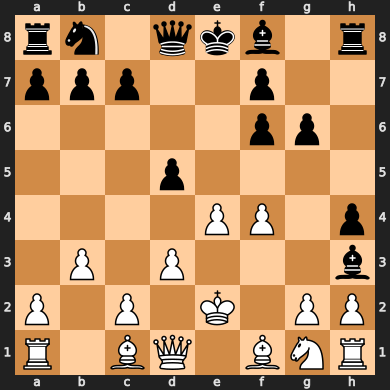

In [30]:
r = 0

print(list_of_results[r] * (list_of_results[r] * 2) - 0.5)

y = numpy.zeros(shape=[1, 752])
y[0] += list_of_tests[r]
print(model.predict(y))
print(input_to_board(list_of_tests[r]).fen)
input_to_board(y[0])

In [60]:
b = chess.Board()


h3h4


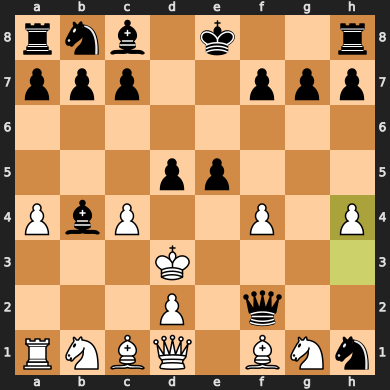

In [84]:
m = avocado_move(b)
b.push(m)
b


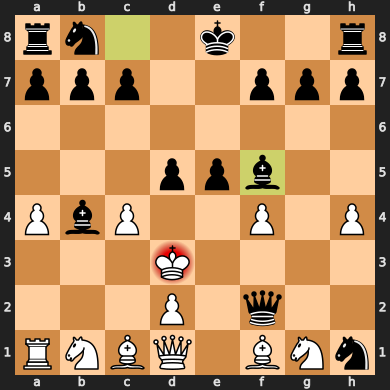

In [85]:
b.push(chess.Move.from_uci("c8f5"))
b

In [87]:
print(b.is_checkmate())

True


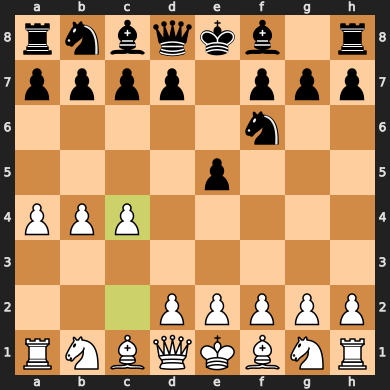

In [69]:
b.pop()
b

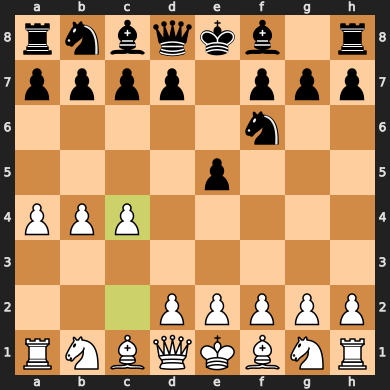

In [70]:
b

In [45]:

def avocado_move(board):
  moves = list(board.legal_moves)
  eval = 0
  chosed_move = moves[0]
  for move in moves:
    board.push(move)
    z = numpy.zeros(shape=[1, 752])
    z[0] = one_dimension_board(board)
    aux_eval = model.predict(z)
    if aux_eval > eval:
      chosed_move = move
    
    board.pop()

  print(chosed_move)
  return chosed_move

def enemy_move(engine):
  result = engine.analyse(board, chess.engine.Limit(depth=10))
  return result['pv'][0]


# with chess.engine.SimpleEngine.popen_uci(stockfish_path) as fish:
#   board = chess.Board()
#   while True:
#     move = avocado_move()
#     board.push(move)
#     print(f'\n{board}')

#     move = enemy_move(fish)
#     board.push(move)
#     print(f'\n{board}')

#     if board.is_game_over():
#       print(len(board.move_stack))
#       print(board.is_fifty_moves())
#       print(board.is_checkmate())
#       print(board.is_fivefold_repetition())
#       print('GAME OVER')
#       break


In [9]:
def input_to_board(one_d_input):
  board_from_input = chess.Board().empty()
  board_from_input.empty

  count = -1

  #WHITE
  for pos in range(752):
    count += 1
    if (pos <= 55):
      if (one_d_input[pos] == 1):
        rank = rank_pos(0, pos)
        board_from_input.set_piece_at(chess.square(count,rank+1), chess.Piece(chess.PAWN, chess.WHITE))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 119):
      if (one_d_input[pos] == 1):
        rank = rank_pos(56, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.KNIGHT, chess.WHITE))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 183):
      if (one_d_input[pos] == 1):
        rank = rank_pos(120, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.BISHOP, chess.WHITE))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 247):
      if (one_d_input[pos] == 1):
        rank = rank_pos(184, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.ROOK, chess.WHITE))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 311):
      if (one_d_input[pos] == 1):
        rank = rank_pos(248, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.QUEEN, chess.WHITE))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 375):
      if (one_d_input[pos] == 1):
        rank = rank_pos(312, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.KING, chess.WHITE))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

  #BLACK
    elif (pos <= 439):
      if (one_d_input[pos] == 1):
        rank = rank_pos(376, pos)
        board_from_input.set_piece_at(chess.square(count,rank+1), chess.Piece(chess.PAWN, chess.BLACK))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 503):
      if (one_d_input[pos] == 1):
        rank = rank_pos(432, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.KNIGHT, chess.BLACK))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 567):
      if (one_d_input[pos] == 1):
        rank = rank_pos(496, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.BISHOP, chess.BLACK))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1
    elif (pos <= 631):
      if (one_d_input[pos] == 1):
        rank = rank_pos(560, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.ROOK, chess.BLACK))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 695):
      if (one_d_input[pos] == 1):
        rank = rank_pos(624, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.QUEEN, chess.BLACK))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1

    elif (pos <= 759):
      if (one_d_input[pos] == 1):
        rank = rank_pos(688, pos)
        board_from_input.set_piece_at(chess.square(count,rank), chess.Piece(chess.KING, chess.BLACK))
        if (count >= 7):
          count = -1
      elif (count >= 7):
        count = -1
  return board_from_input

r n b . k . n r
. p p p . . p p
. . . b . p N .
p . . . p . . .
P . . . . . . .
. . . P . P . .
R P P . P . P P
. N B Q K B . R


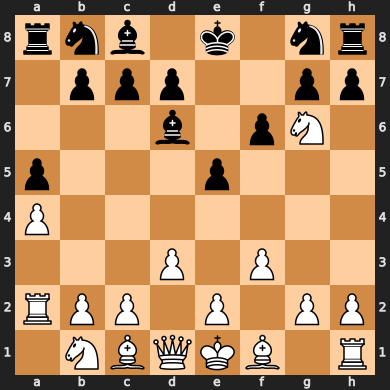

In [165]:
test_b = random_board(20)
one_d_input = one_dimension_board(test_b)
# print(input_to_board(one_dimension_board(test_b)))

board_from_input = input_to_board(one_d_input)

print(test_b)
board_from_input

In [8]:
def build_model():
  build = tf.keras.models.Sequential()
  build.add(tf.keras.layers.Input(752))
  build.add(tf.keras.layers.Dense(752, activation='relu'))
  build.add(tf.keras.layers.Dense(752, activation='relu'))
  build.add(tf.keras.layers.Dense(752, activation='relu'))
  build.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return build;

def random_board(max_depth=200):
  rand_board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(rand_board.legal_moves)
    random_move = random.choice(all_moves)
    rand_board.push(random_move)
    if rand_board.is_game_over():
      break

  return rand_board

def print_input(input_to_print):
  concatenate = ''
  for pos in range(752):
    if (pos != 0 and pos % 8 == 0):
      print(concatenate)
      concatenate = ''
    concatenate = (concatenate + ' ' + str(input_to_print[pos]))

def enemy_analyses(engine):
  result = engine.analyse(board, chess.engine.Limit(depth=10))
  return result['score'].white().score()

def one_dimension_board(two_d):
  board1d = numpy.zeros(752, dtype=numpy.int8)
  
  w_pawns = numpy.zeros(56, dtype=numpy.int8)
  w_knt = numpy.zeros(64, dtype=numpy.int8)
  w_bp = numpy.zeros(64, dtype=numpy.int8)
  w_rk = numpy.zeros(64, dtype=numpy.int8)
  w_q = numpy.zeros(64, dtype=numpy.int8)
  w_ki = numpy.zeros(64, dtype=numpy.int8)

  b_pawns = numpy.zeros(56, dtype=numpy.int8)
  b_knt = numpy.zeros(64, dtype=numpy.int8)
  b_bp = numpy.zeros(64, dtype=numpy.int8)
  b_rk = numpy.zeros(64, dtype=numpy.int8)
  b_q = numpy.zeros(64, dtype=numpy.int8)
  b_ki = numpy.zeros(64, dtype=numpy.int8)

  #WHITE
  sq_w_p = two_d.pieces(chess.PAWN, chess.WHITE)
  l_w_p = list(sq_w_p)
  for pos in l_w_p:
    w_pawns[pos-8] = 1

  sq_w_k = two_d.pieces(chess.KNIGHT, chess.WHITE)
  l_w_k = list(sq_w_k)
  for pos in l_w_k:
    w_knt[pos] = 1

  sq_w_bp = two_d.pieces(chess.BISHOP, chess.WHITE)
  l_w_bp = list(sq_w_bp)
  for pos in l_w_bp:
    w_bp[pos] = 1

  sq_w_rk = two_d.pieces(chess.ROOK, chess.WHITE)
  l_w_rk = list(sq_w_rk)
  for pos in l_w_rk:
    w_rk[pos] = 1

  sq_w_q = two_d.pieces(chess.QUEEN, chess.WHITE)
  l_w_q = list(sq_w_q)
  for pos in l_w_q:
    w_q[pos] = 1

  sq_w_k = two_d.pieces(chess.KING, chess.WHITE)
  l_w_k = list(sq_w_k)
  for pos in l_w_k:
    w_ki[pos] = 1

  #BLACK
  sq_b_p = two_d.pieces(chess.PAWN, chess.BLACK)
  l_b_p = list(sq_b_p)
  for pos in l_b_p:
    b_pawns[pos-8] = 1

  sq_b_k = two_d.pieces(chess.KNIGHT, chess.BLACK)
  l_b_k = list(sq_b_k)
  for pos in l_b_k:
    b_knt[pos] = 1

  sq_b_bp = two_d.pieces(chess.BISHOP, chess.BLACK)
  l_b_bp = list(sq_b_bp)
  for pos in l_b_bp:
    b_bp[pos] = 1

  sq_b_rk = two_d.pieces(chess.ROOK, chess.BLACK)
  l_b_rk = list(sq_b_rk)
  for pos in l_b_rk:
    b_rk[pos] = 1

  sq_b_q = two_d.pieces(chess.QUEEN, chess.BLACK)
  l_b_q = list(sq_b_q)
  for pos in l_b_q:
    b_q[pos] = 1

  sq_b_k = two_d.pieces(chess.KING, chess.BLACK)
  l_b_k = list(sq_b_k)
  for pos in l_b_k:
    b_ki[pos] = 1

  board1d = numpy.concatenate((
    numpy.concatenate((
    numpy.concatenate((
    numpy.concatenate((
    numpy.concatenate((w_pawns, w_knt)),
    w_bp)), w_rk)), w_q)), w_ki))

  board1d = numpy.concatenate((board1d, numpy.concatenate((
    numpy.concatenate((
    numpy.concatenate((
    numpy.concatenate((
    numpy.concatenate((b_pawns, b_knt)),
    b_bp)), b_rk)), b_q)), b_ki))))

  return board1d

In [7]:
def rank_pos(factor, pos):
  aux = pos - factor
  if aux >= 0 and aux < 8:
    return 0
  if aux >= 8 and aux < 16:
    return 1
  if aux >= 16 and aux < 24:
    return 2
  if aux >= 24 and aux < 32:
    return 3
  if aux >= 32 and aux < 40:
    return 4
  if aux >= 40 and aux < 48:
    return 5
  if aux >= 48 and aux < 56:
    return 6
  if aux >= 56 and aux < 64:
    return 7